In [43]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq 
using BenchmarkTools

In [44]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb)
    popup_t = []
    nbr_error_t = []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

         # Load the functions
        fsolve(du, u, p, t) = f(du, u, p0)
        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))

        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                    reltol=1.0e-6,
                    abstol=1.0e-8)

        if SciMLBase.successful_retcode(sol)
            push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(T)])
        else
            push!(nbr_error_t, i)
        end
    end
    return popup_t, nbr_error_t 
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

min_r0

### Define the system

In [45]:
# Nbr of particles
N = 2
r = 10 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 2e3 # atoms per unit of volume (already normalized)
d0_lb = 2e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb/λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

### Compute stationnary state for r repetitions

In [46]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [47]:
# Prepare the function
libpath ="libs/liballfuncs_$N.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f (generic function with 1 method)

In [48]:
@load "op_list/op_list_$N.jdl2" op_list
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
    Threads.@spawn solve_random_distrib(chunk, f, op_list, N, n0, d0_lb)
end

# Gather the data from the different threads
sol_tasks = fetch.(tasks)
popup_t = vcat([s[1] for s in sol_tasks]...)
nbr_error_t = vcat([s[2] for s in sol_tasks]...)
print("Nbr errors = "*string(length(nbr_error_t)))

Nbr errors = 0

In [49]:
@save "solutions/sol_N_$(N)_r_$(r)" popup_t nbr_error_t

In [50]:
@load "solutions/sol_N_$(N)_r_$(r)" popup_t nbr_error_t

2-element Vector{Symbol}:
 :popup_t
 :nbr_error_t

# Plots

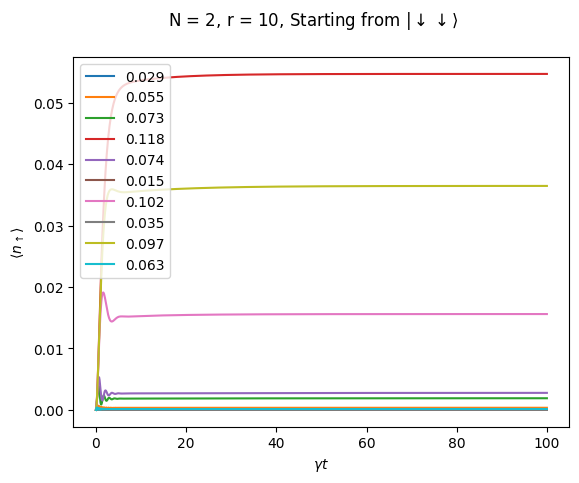

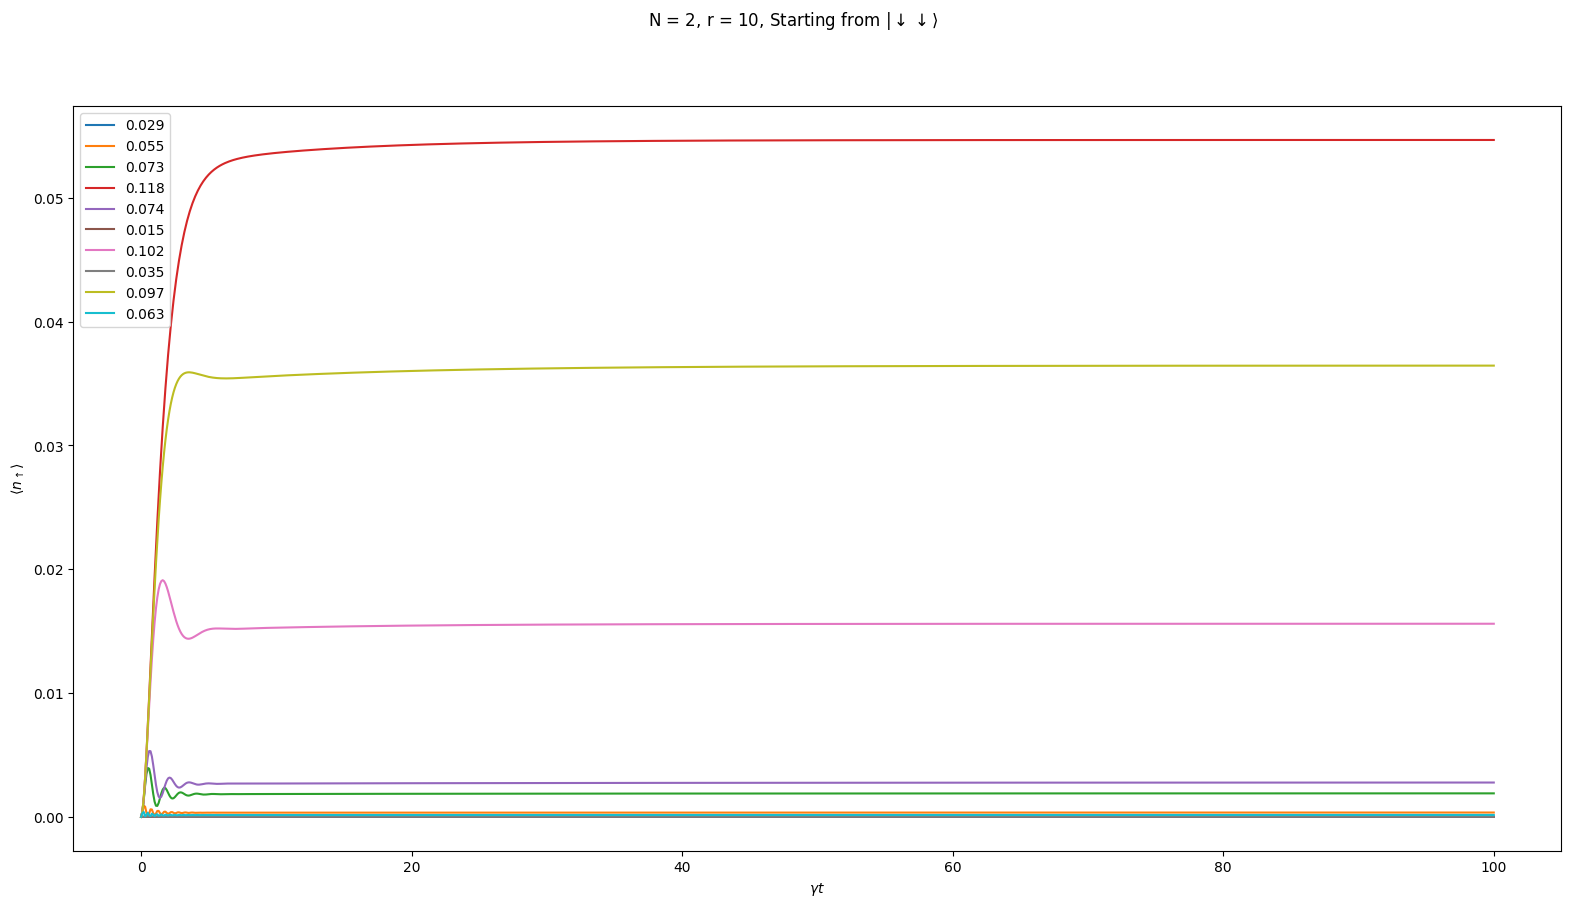

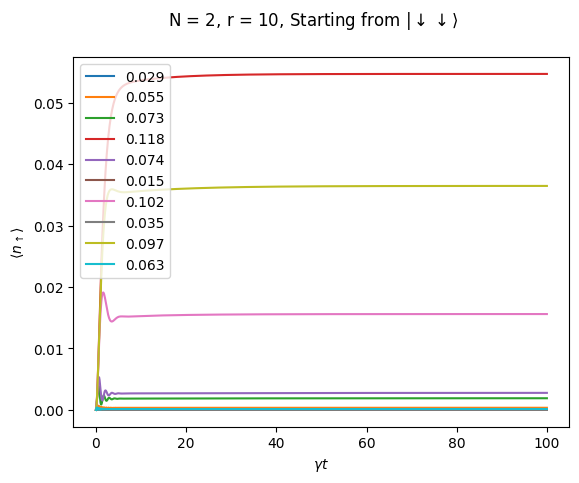

In [56]:
fig, ax = subplots()
for i in 1:length(popup_t)
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L 
    line, = ax.plot(T, popup_t[i], label=round(min_r0(r0), digits=3))
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
legend()
pygui(false);
# pygui(true); show()